# Реализация внесения искажений в слова (Гареева)

### Функция сложности слова

In [1]:
%run scripts/word_difficulty.py

### Ударения

Скачаем датасет ударений для проверки безударных мест.

In [2]:
fullname = save_zip_csv(url='https://github.com/Koziev/NLP_Datasets/raw/master/Stress/all_accents.zip',
                        dirname='datasets/stress',
                        new_filename='all_accents.tsv')
stress_df = pd.read_csv(fullname, sep='\t', names=['Lemma', 'stress'])
stress_df = stress_df.drop_duplicates(subset=['Lemma'])
stress_df = stress_df.set_index('Lemma')
stress_df.head(10)

,stress
Lemma,
-де,-д^е
-ка,-к^а
-либо,-л^ибо
-нибудь,-ниб^удь
-с,-с
-таки,-так^и
-то,-т^о
­вычеркнуть,­в^ычеркнуть
а,^а


### Получение морфем слова

Многие неочевидные места в правописании слова зависят от морфемы, поэтому было бы здорово учитывать их, если это возможно.

In [3]:
def get_morphs_list(lemma: str) -> List[str]:
    if lemma not in morph_df.index:
        return []
    return list(morph_df.loc[lemma]['analysis'].split('/'))

Протестируем

In [4]:
word='недисциплинированный'
print(get_morphs_list(lemma=word))

['не', 'дисциплин', "и'р", 'ова', 'нн', 'ый']


### Отбор наиболее подходящих искажений

Так как мы не сможем брать все искажения - для тестов это неудобно, будет отбирать несколько самых подходящих искажений там, где это необходимо. Наиболее подходящие искажения будем определять следующим образом: 
1. Возьмем большой список лемм - к примеру из **morph_df**.
2. Для каждой буквы каждого слова посчитаем количество разнообразных букв, идущих за ней, и разделим полученные результаты на максимальный для каждого слова, чтобы отнормировать результаты от 0 до 1.
3. Для слова-искажения будем брать среднее значение результатов для каждой буквы.
4. Будем брать слова-искажения с самым большим полученным значением.

In [5]:
from collections import defaultdict

letters_dict = dict()
letters = set('абвгдежзийклмнопрстуфхцчшщъыьэюя')
for word in morph_df.index:
    for i in range(len(word) - 1):
        c = word[i]
        next_c = word[i + 1]
        if c in letters and next_c in letters:
            if c not in letters_dict:
                letters_dict[c] = defaultdict(int)
            letters_dict[c][next_c] += 1
letter_df = pd.DataFrame.from_dict(letters_dict, orient='index').fillna(0)
letter_df = letter_df.div(letter_df.max(axis=1), axis=0)
letter_df

,а,о,и,т,ц,е,с,з,л,р,...,ю,ф,б,г,ж,я,щ,й,э,ъ
к,1.000000,0.732610,0.593780,0.140574,0.021023,0.045243,0.068301,0.006588,0.151424,0.254021,...,0.001550,0.000194,0.000484,0.000484,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000
л,0.586393,0.892337,0.918998,0.035256,0.001020,1.000000,0.012821,0.011946,0.102855,0.000000,...,0.130682,0.001311,0.013549,0.016754,0.011218,0.268502,0.001603,0.000000,0.000000,0.000000
и,0.068037,0.150143,0.005091,1.000000,0.161992,0.439600,0.438026,0.322966,0.201148,0.437471,...,0.001389,0.047950,0.054244,0.091456,0.033232,0.211700,0.036842,0.694529,0.001851,0.000000
б,0.743445,1.000000,0.631303,0.035498,0.014522,0.937878,0.137152,0.011295,0.516337,0.817265,...,0.027027,0.001210,0.012505,0.011295,0.036305,0.022590,0.064542,0.000000,0.002420,0.045986
н,0.347816,0.409574,0.618757,0.138074,0.022508,0.256439,0.069653,0.008287,0.000672,0.001624,...,0.004591,0.009351,0.000560,0.024748,0.005655,0.054815,0.006495,0.000000,0.000784,0.000840
у,0.062667,0.012000,0.030333,1.000000,0.019667,0.030667,0.562000,0.178333,0.449667,0.613333,...,0.064333,0.026000,0.379667,0.254667,0.247667,0.014000,0.113000,0.020000,0.010667,0.000000
д,0.527943,1.000000,0.701286,0.031652,0.031157,0.847923,0.173591,0.022255,0.075420,0.315529,...,0.013600,0.001731,0.027201,0.033630,0.031652,0.037092,0.002473,0.000000,0.002473,0.022997
о,0.014577,0.061531,0.061992,0.501534,0.030536,0.055777,0.554857,0.169019,0.539359,0.591376,...,0.003146,0.053782,0.371720,0.247583,0.101504,0.020868,0.027006,0.152447,0.011969,0.000000
т,0.168169,0.235430,0.216817,0.008601,0.001858,0.206736,0.029691,0.000929,0.016067,0.196725,...,0.005367,0.000963,0.004473,0.004301,0.001307,0.015860,0.001892,0.000000,0.000482,0.000929
а,0.001538,0.003403,0.021584,1.000000,0.056314,0.014218,0.234535,0.158361,0.254673,0.236865,...,0.015757,0.033425,0.071419,0.071745,0.053704,0.015570,0.021957,0.022143,0.005874,0.000000


In [6]:
def get_word_probability(word: str) -> int:
    probability = 0
    amount = 0
    for i in range(len(word) - 1):
        c = word[i]
        next_c = word[i + 1]
        if c in letters and next_c in letters:
            probability += letter_df.loc[c][next_c]
            amount += 1
    return probability / amount if amount else 0

def get_n_best_words(words, max_amount: int=1) -> List[str]:
    if max_amount < len(words):
        return sorted(list(words), key=lambda word: get_word_probability(word), reverse=True)[:max_amount]
    return list(words)

Протестируем

In [7]:
print(get_word_probability('собирается'))
print(get_word_probability('соберается'))
print(get_word_probability('сабирается'))
print(get_n_best_words(['собирается', 'соберается', 'сабирается'], max_amount=2))
print(get_word_probability('жизнь'))
print(get_word_probability('жызнь'))
print(get_n_best_words(['жизнь', 'жызнь'], max_amount=3))

0.4293764002143299
0.5192654313584053
0.3839760169451163
['соберается', 'собирается']
0.402000381746182
0.07404077887675957
['жизнь', 'жызнь']


### Безударные гласные

Будем заменять безударные О и Е в слове на А и И. Определять безударность с помощью списка морфем с ударениями.

In [8]:
stress_vowels_dict = {'о':'а', 'а':'о', 'е':'и', 'и':'е', 'я':'е'}

def stress_vowels_distortion(word: str, stress_word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:  
    def do_distortion(word_: str, stress_word: str) -> None:
        if 0 <= stress_word.find('^') < len(stress_word) - 2:
            i = stress_word.find('^')
            stress_word = stress_word[:i] + stress_word[i + 1].upper() + stress_word[i + 2:]
        else:
            return []
        for i in range(1, len(word_) - 3):
            if i < len(stress_word) and stress_word[i] in stress_vowels_dict and stress_word[i] == word_[i]:
                distortion = word_[:i] + stress_vowels_dict[word_[i]] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion, stress_word)
        
    distortions = set()
    do_distortion(word, stress_word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [9]:
word='победитель'
print(stress_vowels_distortion(word, stress_word=stress_df.loc[word]['stress'], max_amount=2))
word='гриб'
print(stress_vowels_distortion(word, stress_word=stress_df.loc[word]['stress'], max_amount=2))
print(stress_vowels_distortion('написаные', stress_word=stress_df.loc['написанные']['stress'], max_amount=2))

['пабедитель', 'побидитель']
[]
['нописаные', 'написоные']


### Парные по глухости/звонкости согласные

Заменим парные звонкие согласные в конце слова или перед глухими на их пару.

In [10]:
deaf_consonants = set('пфктшсхцчщ')
consonants_pairs = {
    'б':'п', 
    'г':'к', 
    'д':'т', 
    'ж':'ш', 
    'з':'с', 
}

def consonants_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:  
    def do_distortion(word_: str) -> None:
        for i in range(len(word_)):
            distortion = None
            c = word_[i] 
            after_c = word_[i + 1] if i < len(word_) - 1 else None
            if c in consonants_pairs and (i == len(word_) - 1 or after_c in deaf_consonants):
                distortion = word_[:i] + consonants_pairs[c] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [11]:
word='тетрадка'
print(consonants_distortion(word))
word='гриб'
print(consonants_distortion(word))
word='отвориться'
print(consonants_distortion(word))

['тетратка']
['грип']
[]


### Чередование безударных гласных в корне

Заменим корни с помощью спика морфем на их пару.

In [12]:
root_pairs = {'раст':'рост', 'ращ':'рощ', 'рос':'рас',
               'лаг':'лог', 'лож':'лаж',
               'скак':'скок', 'скоч':'скач',
               'гар':'гор', 'гор':'гар', 
               'твар':'твор','твор':'твар', 
               'клан':'клон', 'клон':'клан',
               'зар':'зор', 'зор':'зар',
               'плав':'плов', 'плов':'плав',
               'мак':'мок', 'моч':'мач',
               'равн':'ровн', 'ровн':'равн',
               'бер':'бир', 'бир':'бер',
               'дер':'дир', 'дир':'дер',
               'пер':'пир', 'пир':'пер',
               'тер':'тир', 'тир':'тер',
               'мер':'мир', 'мир':'мер',
               'жег':'жиг', 'жиг':'жег',
               'стел':'стил', 'стил':'стел',
               'блест':'блист', 'блист':'блест',
               'чет':'чит', 'чит':'чет',
               'кас':'кос', 'кос':'кас'}
    
def roots_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in root_pairs and morph == word_[index:index + len(morph)]:
                distortion = word_[:index] + root_pairs[morph] + word_[index + len(morph):]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))

    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [13]:
word = 'отвориться'
print(roots_distortion(word, morphs_list=get_morphs_list(word)))
word = 'послушаться'
print(roots_distortion(word, morphs_list=get_morphs_list(word)))

['отвариться']
[]


### Правописание приставок

Заменим приставки с помощью спика морфем на их пару.

In [14]:
prefix_pairs = {'пре':'при', 'при':'пре',
                'без':'бес', 'бес':'без',
                'воз':'вос', 'вос':'воз',
                'вз':'вс', 'вс':'вз',
                'из':'ис', 'ис':'из',
                'низ':'нис', 'нис':'низ',
                'раз':'рас', 'рас':'раз',
                'роз':'рос', 'рос':'роз',
                'чрез':'чрес', 'чрес':'чрез'}

def prefixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in prefix_pairs and morph == word_[index:index + len(morph)]:
                distortion = word_[:index] + prefix_pairs[morph] + word_[index + len(morph):]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [15]:
word = 'приподняться'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'бесприданница'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word), max_amount=2))
word = 'отвориться'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))

['преподняться']
['беспреданница', 'безпреданница']
[]


### Гласные Ы и И после приставок

In [16]:
vowels_after_prefixs_pairs = {'и':'ы', 'ы':'и'}

def vowels_after_prefixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount and morphs_list:
        morph = morphs_list[0].replace('\'', '')
        if len(morph) < len(word) and word[len(morph)] in vowels_after_prefixs_pairs:
            distortion = word[:len(morph)] +\
                        vowels_after_prefixs_pairs[word[len(morph)]] +\
                        word[len(morph) + 1:]
            if distortion != word:
                return [distortion]
    return []

Протестируем

In [17]:
word = 'межирригационный'
print(vowels_after_prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'предыстория'
print(vowels_after_prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'предыстория'
print(vowels_after_prefixs_distortion(word, morphs_list=get_morphs_list(word), max_amount=0))
word = 'отвориться'
print(vowels_after_prefixs_distortion(word, morphs_list=get_morphs_list(word)))

['межырригационный']
['предистория']
[]
[]


### Правописание ться/тся

Заменим постфикс слова ться на тся и наоборот.

In [18]:
postfix_pairs = {'тся':'ться', 'ться':'тся'}

def postfixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount:
        for postfix in postfix_pairs:
            if word[-len(postfix):] == postfix:
                return [word[:-len(postfix)] + postfix_pairs[postfix]]
    return []

Протестируем

In [19]:
word = 'приподняться'
print(postfixs_distortion(word))
word = 'приподнятся'
print(postfixs_distortion(word))
word = 'приподнятся'
print(postfixs_distortion(word, max_amount=0))
word = 'приподнялась'
print(postfixs_distortion(word))

['приподнятся']
['приподняться']
[]
[]


### Двойные согласные

Удалим двойные согласные и добавим лишнюю н у суффиксов ан, ян, ын, ин.

In [20]:
vowels = set('аяоёуюыиэе')

def two_in_row_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        for i in range(len(word_)):
            if i > 0 and word_[i - 1] == word_[i] and word_[i] not in vowels:
                distortion = word_[:i] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

single_suffixs = set(['ан', 'ян', 'ын', 'ин'])

def duplicate_distortion(word: str, morphs_list: List[str], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            morph = morph.replace('\'', '')
            if morph in single_suffixs and morph == word_[index:index + len(morph)] and\
                index + len(morph) < len(word) and word_[index + len(morph) - 1] != word_[index + len(morph)]:
                    distortion = word_[:index] + morph + 'н' + word_[index + len(morph):]
                    if distortion not in distortions and distortion != word:
                        distortions.add(distortion)
                        do_distortion(distortion)
            index += len(morph)
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [21]:
word = 'беззаконный'
print(two_in_row_distortion(word))
word = 'костяной'
print(two_in_row_distortion(word))
word = 'беззаконный'
print(duplicate_distortion(word, morphs_list=get_morphs_list(word)))
word = 'костяной'
print(duplicate_distortion(word, morphs_list=get_morphs_list(word)))

['безаконый']
[]
[]
['костянной']


### Непроизносимые согласные

Удалим непроизносимую букву в наборе подряд идущих согласных. Если таких не нашлось. Поробуем добавить эту лишнюю букву.

In [22]:
silent_consonants_dict = {'стн':'сн',
                          'стл':'сл',
                          'ндш':'нш',
                          'ндц':'нц',
                          'нтг':'нг',
                          'здн':'зн',
                          'здц':'зц',
                          'рдц':'рц',
                          'рдч':'рч',
                          'лнц':'нц',
                          'вств':'ств'}

def silent_consonants_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        for key, value in silent_consonants_dict.items():
            distortion = word_.replace(key, value, 1)
            if distortion not in distortions and distortion != word:
                distortions.add(distortion)
                do_distortion(distortion)
        if len(distortions) == 0:
            for key, value in silent_consonants_dict.items():
                distortion = word_.replace(value, key, 1)
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
    
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

Протестируем

In [23]:
word = 'солнце'
print(silent_consonants_distortion(word))
word = 'чувство'
print(silent_consonants_distortion(word))
word = 'ужасный'
print(silent_consonants_distortion(word))
word = 'стнстл'
print(silent_consonants_distortion(word, max_amount=2))
word = 'костяной'
print(silent_consonants_distortion(word))

['сонце']
['чуство']
['ужастный']
['стнсл', 'снстл']
[]


### Твердый знак

Заменим твердый знак на мягкий.

In [24]:
def hard_sign_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount and 'ъ' in set(word):
        return [word.replace('ъ', 'ь', 1)]
    return []

Протестируем

In [25]:
word = 'объём'
print(hard_sign_distortion(word))
word = 'объём'
print(hard_sign_distortion(word, max_amount=0))
word = 'солнце'
print(hard_sign_distortion(word))

['обьём']
[]
[]


### Дефисные написания

Уберем дефисы или заменим на пробел.

In [26]:
def hyphen_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 1 < max_amount and '-' in set(word):
        return [word.replace('-', ' '), word.replace('-', '')]
    if 0 < max_amount and '-' in set(word):
        return [word.replace('-', '')]
    return []

Протестируем

In [27]:
word = 'все-таки'
print(hyphen_distortion(word, max_amount=3))
word = 'все-таки'
print(hyphen_distortion(word, max_amount=1))
word = 'все-таки'
print(hyphen_distortion(word, max_amount=0))
word = 'костяной'
print(hyphen_distortion(word))

['все таки', 'всетаки']
['всетаки']
[]
[]


### Финальная функция внесения искажений в слова

Скомбинируем все созданные искажения, начиная с более узких правил, которые зависят от морфем, заканчивая самыми простыми заменями согласных и гласных. Ограничим количество полученных искажений переменной **max_amount**.

In [28]:
def create_distortions(word: str, lemma: str, max_amount: int=6) -> List[str]:
    morphs_list=get_morphs_list(lemma)    
    distortions = set([word])
    
    def do_function(func, stress: bool=False) -> None:
        result = set()
        amount = (max_amount // len(distortions)) - 1
        for distortion in distortions:
            if stress:
                if word in stress_df.index:
                    stress_word = stress_df.loc[word]['stress']
                    result.update(func(distortion, stress_word, morphs_list, amount))
            else:
                result.update(func(distortion, morphs_list, amount))
        distortions.update(result)     

    do_function(roots_distortion)
    do_function(prefixs_distortion)
    do_function(vowels_after_prefixs_distortion)
    do_function(postfixs_distortion)
    do_function(two_in_row_distortion)
    do_function(duplicate_distortion)
    do_function(silent_consonants_distortion)
    do_function(hard_sign_distortion)
    do_function(hyphen_distortion)
    do_function(consonants_distortion)
    do_function(stress_vowels_distortion, True)
    
    distortions.remove(word)
    return list(distortions)

Протестируем

In [29]:
print(create_distortions(word='написанные', lemma='написанный'))
print(create_distortions(word='бессмысленное', lemma='бессмысленный'))
print(create_distortions(word='собирается', lemma='собираться'))
print(create_distortions(word='престаринного', lemma='престаринный'))

['нописаные', 'нописанные', 'написоные', 'написаные', 'написонные']
['безсмысленое', 'бесмысленное', 'безсмысленное', 'бесмысленое']
['собераеться', 'соберается', 'собираеться']
['престариного']


### Проверка работы функции

Напишем функции для создания датасета слов повышенной сложности с искажениями из текстового документа со словами и визуализации количества полученных искажений.

In [30]:
def countplot_distortions_df(distortions_df: pd.DataFrame) -> None:
    print('Всего слов: {}'.format(len(distortions_df)))
    print('Слов без искажений: {}'.format(len(distortions_df[distortions_df['distortions_amount'] == 0])))
    print('Слов с искажениями: {}'.format(len(distortions_df[distortions_df['distortions_amount'] != 0])))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.countplot(x=distortions_df[distortions_df['distortions_amount'] != 0]['distortions_amount'])
    ax.set_title('Количество слов с определенном количеством искажений')
    ax.set_ylabel('Количество слов')
    ax.set_xlabel('Количество искажений')
    
    plt.show()
    
def analyze_distortions(filepath: str, stop=None, show_plot=True) -> pd.DataFrame:
    distortions_df = pd.DataFrame(columns=['distortions', 'distortions_amount'])
    with open(filepath, 'rb') as f:
        for i, word in enumerate(tqdm(f.read().decode('utf-8').split())):
            word = transform_word(word)[0]
            if word and word not in distortions_df.index and word.find('-') < 0:
                difficulty = word_difficulty(word)
                if 0.5 <= difficulty['difficulty']:
                    distortions = create_distortions(word, difficulty['lemma'])
                    info = {'distortions': distortions,
                            'distortions_amount': len(distortions),
                            'difficulty': difficulty['difficulty']}
                    row = pd.Series(info, name=word)
                    distortions_df = distortions_df.append(row)
            if stop and stop <= i:
                break
    if show_plot:
        countplot_distortions_df(distortions_df)
    return distortions_df

Возьмем небольшой текст, чтобы мы могли протестировать внесение искажений. Например, отрывок из 'Алисы в стране чудес' Льюиса Кэрролла.

In [31]:
alice_in_wonderland_fullname = save_zip_txt(url='https://royallib.com/get/txt/keroll_lyuis/alisa_v_strane_chudes.zip',
                                     dirname='datasets/texts/alice_in_wonderland/',
                                     new_filename='alice_in_wonderland.txt')

100%|███████████████████████████████████████████████████████████████████████████| 28613/28613 [01:22<00:00, 346.47it/s]


Всего слов: 1397
Слов без искажений: 105
Слов с искажениями: 1292


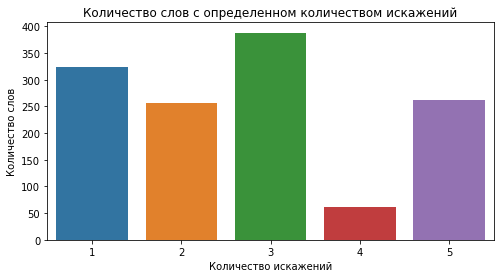

,distortions,distortions_amount,difficulty
word,,,
возобновилось,"[вособновилось, восабновилось, васобновилось, ...",5,0.880897
непререкаемо,"[непририкаемо, неприрекаемо, ниприрекаемо, неп...",5,0.884922
победоносно,"[побидоносно, победаносно, побидоностно, побед...",5,0.892810
проникновенным,"[пронекновенным, пронекновеным, праникновеным,...",5,0.894737
подчеркивают,"[подчиркивают, потчиркивают, потчеркивают, пот...",5,0.900000
несообразности,"[несаобразности, несаобраздности, несообраздно...",5,0.933333
перекрестному,"[перекресному, пирекресному, перикресному, пер...",5,0.950000
непревзойденным,"[нипревзойденым, непревзойденым, непревзайдены...",5,1.000000
постепенностью,"[постепеннастью, постипенностью, постипеностью...",5,1.000000


In [32]:
distortions_df = analyze_distortions(filepath=alice_in_wonderland_fullname, stop=None)
distortions_df.rename_axis('word').sort_values(by=['distortions_amount', 'difficulty', 'word']).tail(10)

# Весь нужный код

In [33]:
from collections import defaultdict


# Функция сложности слова
exec(open('scripts/word_difficulty.py').read())


# Датасеты
fullname = save_zip_csv(url='https://github.com/Koziev/NLP_Datasets/raw/master/Stress/all_accents.zip',
                        dirname='datasets/stress',
                        new_filename='all_accents.tsv')
stress_df = pd.read_csv(fullname, sep='\t', names=['Lemma', 'stress'])
stress_df = stress_df.drop_duplicates(subset=['Lemma'])
stress_df = stress_df.set_index('Lemma')

letters_dict = dict()
letters = set('абвгдежзийклмнопрстуфхцчшщъыьэюя')
for word in morph_df.index:
    for i in range(len(word) - 1):
        c = word[i]
        next_c = word[i + 1]
        if c in letters and next_c in letters:
            if c not in letters_dict:
                letters_dict[c] = defaultdict(int)
            letters_dict[c][next_c] += 1
letter_df = pd.DataFrame.from_dict(letters_dict, orient='index').fillna(0)
letter_df = letter_df.div(letter_df.max(axis=1), axis=0)


# Вспомогательные функции
def get_morphs_list(lemma: str) -> List[str]:
    if lemma not in morph_df.index:
        return []
    return list(morph_df.loc[lemma]['analysis'].split('/'))

def get_word_probability(word: str) -> int:
    probability = 0
    amount = 0
    for i in range(len(word) - 1):
        c = word[i]
        next_c = word[i + 1]
        if c in letters and next_c in letters:
            probability += letter_df.loc[c][next_c]
            amount += 1
    return probability / amount if amount else 0

def get_n_best_words(words, max_amount: int=1) -> List[str]:
    if max_amount < len(words):
        return sorted(list(words), key=lambda word: get_word_probability(word), reverse=True)[:max_amount]
    return list(words)

stress_vowels_dict = {'о':'а', 'а':'о', 'е':'и', 'и':'е', 'я':'е'}

def stress_vowels_distortion(word: str, stress_word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:  
    def do_distortion(word_: str, stress_word: str) -> None:
        if 0 <= stress_word.find('^') < len(stress_word) - 2:
            i = stress_word.find('^')
            stress_word = stress_word[:i] + stress_word[i + 1].upper() + stress_word[i + 2:]
        else:
            return []
        for i in range(1, len(word_) - 3):
            if i < len(stress_word) and stress_word[i] in stress_vowels_dict and stress_word[i] == word_[i]:
                distortion = word_[:i] + stress_vowels_dict[word_[i]] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion, stress_word)
        
    distortions = set()
    do_distortion(word, stress_word)
    return get_n_best_words(distortions, max_amount)

deaf_consonants = set('пфктшсхцчщ')
consonants_pairs = {
    'б':'п', 
    'г':'к', 
    'д':'т', 
    'ж':'ш', 
    'з':'с', 
}

def consonants_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:  
    def do_distortion(word_: str) -> None:
        for i in range(len(word_)):
            distortion = None
            c = word_[i] 
            after_c = word_[i + 1] if i < len(word_) - 1 else None
            if c in consonants_pairs and (i == len(word_) - 1 or after_c in deaf_consonants):
                distortion = word_[:i] + consonants_pairs[c] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

root_pairs = {'раст':'рост', 'ращ':'рощ', 'рос':'рас',
               'лаг':'лог', 'лож':'лаж',
               'скак':'скок', 'скоч':'скач',
               'гар':'гор', 'гор':'гар', 
               'твар':'твор','твор':'твар', 
               'клан':'клон', 'клон':'клан',
               'зар':'зор', 'зор':'зар',
               'плав':'плов', 'плов':'плав',
               'мак':'мок', 'моч':'мач',
               'равн':'ровн', 'ровн':'равн',
               'бер':'бир', 'бир':'бер',
               'дер':'дир', 'дир':'дер',
               'пер':'пир', 'пир':'пер',
               'тер':'тир', 'тир':'тер',
               'мер':'мир', 'мир':'мер',
               'жег':'жиг', 'жиг':'жег',
               'стел':'стил', 'стил':'стел',
               'блест':'блист', 'блист':'блест',
               'чет':'чит', 'чит':'чет',
               'кас':'кос', 'кос':'кас'}
    
def roots_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in root_pairs and morph == word_[index:index + len(morph)]:
                distortion = word_[:index] + root_pairs[morph] + word_[index + len(morph):]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))

    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

prefix_pairs = {'пре':'при', 'при':'пре',
                'без':'бес', 'бес':'без',
                'воз':'вос', 'вос':'воз',
                'вз':'вс', 'вс':'вз',
                'из':'ис', 'ис':'из',
                'низ':'нис', 'нис':'низ',
                'раз':'рас', 'рас':'раз',
                'роз':'рос', 'рос':'роз',
                'чрез':'чрес', 'чрес':'чрез'}

def prefixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in prefix_pairs and morph == word_[index:index + len(morph)]:
                distortion = word_[:index] + prefix_pairs[morph] + word_[index + len(morph):]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

vowels_after_prefixs_pairs = {'и':'ы', 'ы':'и'}

def vowels_after_prefixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount and morphs_list:
        morph = morphs_list[0].replace('\'', '')
        if len(morph) < len(word) and word[len(morph)] in vowels_after_prefixs_pairs:
            distortion = word[:len(morph)] +\
                        vowels_after_prefixs_pairs[word[len(morph)]] +\
                        word[len(morph) + 1:]
            if distortion != word:
                return [distortion]
    return []

postfix_pairs = {'тся':'ться', 'ться':'тся'}

def postfixs_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount:
        for postfix in postfix_pairs:
            if word[-len(postfix):] == postfix:
                return [word[:-len(postfix)] + postfix_pairs[postfix]]
    return []

vowels = set('аяоёуюыиэе')

def two_in_row_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        for i in range(len(word_)):
            if i > 0 and word_[i - 1] == word_[i] and word_[i] not in vowels:
                distortion = word_[:i] + word_[i + 1:]
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

single_suffixs = set(['ан', 'ян', 'ын', 'ин'])

def duplicate_distortion(word: str, morphs_list: List[str], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        index = 0
        for morph in morphs_list:
            morph = morph.replace('\'', '')
            if morph in single_suffixs and morph == word_[index:index + len(morph)] and\
                index + len(morph) < len(word) and word_[index + len(morph) - 1] != word_[index + len(morph)]:
                    distortion = word_[:index] + morph + 'н' + word_[index + len(morph):]
                    if distortion not in distortions and distortion != word:
                        distortions.add(distortion)
                        do_distortion(distortion)
            index += len(morph)
            
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

silent_consonants_dict = {'стн':'сн',
                          'стл':'сл',
                          'ндш':'нш',
                          'ндц':'нц',
                          'нтг':'нг',
                          'здн':'зн',
                          'здц':'зц',
                          'рдц':'рц',
                          'рдч':'рч',
                          'лнц':'нц',
                          'вств':'ств'}

def silent_consonants_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    def do_distortion(word_: str) -> None:
        for key, value in silent_consonants_dict.items():
            distortion = word_.replace(key, value, 1)
            if distortion not in distortions and distortion != word:
                distortions.add(distortion)
                do_distortion(distortion)
        if len(distortions) == 0:
            for key, value in silent_consonants_dict.items():
                distortion = word_.replace(value, key, 1)
                if distortion not in distortions and distortion != word:
                    distortions.add(distortion)
                    do_distortion(distortion)
    
    distortions = set()
    do_distortion(word)
    return get_n_best_words(distortions, max_amount)

def hard_sign_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 0 < max_amount and 'ъ' in set(word):
        return [word.replace('ъ', 'ь', 1)]
    return []

def hyphen_distortion(word: str, morphs_list: List[str]=[], max_amount: int=1) -> List[str]:
    if 1 < max_amount and '-' in set(word):
        return [word.replace('-', ' '), word.replace('-', '')]
    if 0 < max_amount and '-' in set(word):
        return [word.replace('-', '')]
    return []


# Основная функция сложности слова
def create_distortions(word: str, lemma: str, max_amount: int=6) -> List[str]:
    morphs_list=get_morphs_list(lemma)    
    distortions = set([word])
    
    def do_function(func, stress: bool=False) -> None:
        result = set()
        amount = (max_amount // len(distortions)) - 1
        for distortion in distortions:
            if stress:
                if word in stress_df.index:
                    stress_word = stress_df.loc[word]['stress']
                    result.update(func(distortion, stress_word, morphs_list, amount))
            else:
                result.update(func(distortion, morphs_list, amount))
        distortions.update(result)     

    do_function(roots_distortion)
    do_function(prefixs_distortion)
    do_function(vowels_after_prefixs_distortion)
    do_function(postfixs_distortion)
    do_function(two_in_row_distortion)
    do_function(duplicate_distortion)
    do_function(silent_consonants_distortion)
    do_function(hard_sign_distortion)
    do_function(hyphen_distortion)
    do_function(consonants_distortion)
    do_function(stress_vowels_distortion, True)
    
    distortions.remove(word)
    return list(distortions)

# Функции анализа искажений .txt
def countplot_distortions_df(distortions_df: pd.DataFrame) -> None:
    print('Всего слов: {}'.format(len(distortions_df)))
    print('Слов без искажений: {}'.format(len(distortions_df[distortions_df['distortions_amount'] == 0])))
    print('Слов с искажениями: {}'.format(len(distortions_df[distortions_df['distortions_amount'] != 0])))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.countplot(x=distortions_df[distortions_df['distortions_amount'] != 0]['distortions_amount'])
    ax.set_title('Количество слов с определенном количеством искажений')
    ax.set_ylabel('Количество слов')
    ax.set_xlabel('Количество искажений')
    
    plt.show()
    
def analyze_distortions(filepath: str, stop=None, show_plot=True) -> pd.DataFrame:
    distortions_df = pd.DataFrame(columns=['distortions', 'distortions_amount'])
    with open(filepath, 'rb') as f:
        for i, word in enumerate(tqdm(f.read().decode('utf-8').split())):
            word = transform_word(word)[0]
            if word and word not in distortions_df.index and word.find('-') < 0:
                difficulty = word_difficulty(word)
                if 0.5 <= difficulty['difficulty']:
                    distortions = create_distortions(word, difficulty['lemma'])
                    info = {'distortions': distortions,
                            'distortions_amount': len(distortions),
                            'difficulty': difficulty['difficulty']}
                    row = pd.Series(info, name=word)
                    distortions_df = distortions_df.append(row)
            if stop and stop <= i:
                break
    if show_plot:
        countplot_distortions_df(distortions_df)
    return distortions_df